In this notebook we will guide you through our solution for the second homework of ADA.

# Part 1: Extracting the options from the dropdown menu

We start with the URL from the [homepage](http://isa.epfl.ch/imoniteur_ISAP/%21gedpublicreports.htm?ww_i_reportmodel=133685247) where you can the select the different years/semesters etc..

In [1]:
%matplotlib inline
import pandas as pd
import requests
from bs4 import BeautifulSoup
import sys
import numpy as np
import matplotlib.pyplot as plt


urlHome = 'http://isa.epfl.ch/imoniteur_ISAP/\
%21gedpublicreports.htm?ww_i_reportmodel=133685247'

We then use requests and BeautifulSoup to import the HTML data from the homepage.

In [2]:
home = requests.get(urlHome)
homeSoup = BeautifulSoup(home.content,'lxml')

The insepetion tool of our browser helped learn that we were to access a #document that is in the frame of one of the framesets of the HTML page, the document is sourced from another page of IS-Academia that we have to access. To access it, we scroll through the framesets and create a list of all the frames. 

In [3]:
iframe = []
for frame in homeSoup.frameset.find_all('frame'):
    iframe.append(frame)

urlOptions = iframe[1]['src']

print(urlOptions)

!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247


The url of the source page is found, we can use it to get the other HTML page. Again we use request and beautifulsoup 
to import the HTML data from this new page.

In [4]:
urlOptions = 'http://isa.epfl.ch/imoniteur_ISAP/' + urlOptions
options = requests.get(urlOptions)
soupOptions = BeautifulSoup(options.content,'lxml')





From this beautifulsoup object we can create a dictionary containing the name of each form parameters as key and the value of each parameters as value. We do this by scrolling to the option tag which contains this information.

In [5]:
#dictionary with the name and the value of each parameters
dic_name_value = {}

#Loop that passes trough all the option tag
for f in soupOptions.find_all('option'):
    
    #Filling of the dictionary
    dic = {f.string : f.attrs["value"]}
    dic_name_value.update(dic)


    
print(dic_name_value)

{'Science et génie des matériaux': '944917', 'Architecture': '942293', 'Stage printemps 4ème année': '2226626', '2014-2015': '213637922', 'Master semestre 1': '2230106', 'Mise à niveau': '2063602308', 'Stage automne 4ème année': '2226616', 'Microtechnique': '945244', 'Master semestre 3': '2230128', '2009-2010': '978195', 'Cours de mathématiques spéciales': '943282', '2016-2017': '355925344', '2013-2014': '213637754', 'Physique': '945571', None: 'null', 'Bachelor semestre 6b': '2226785', 'Mineur semestre 2': '2335676', '2012-2013': '123456101', 'Projet Master printemps': '3781783', 'Bachelor semestre 1': '249108', 'EME (EPFL Middle East)': '637841336', '2015-2016': '213638028', 'Bachelor semestre 2': '249114', 'Bachelor semestre 4': '942163', '2008-2009': '978187', 'Stage printemps 3ème année': '983606', '2011-2012': '123455150', 'Informatique': '249847', 'Master semestre 2': '942192', 'Humanités digitales': '2054839157', 'Stage automne 3ème année': '953137', 'Semestre de printemps': '2

We separate this dictionary into smaller dictionaries specific to each form parameters. Which means one for the section, one for the academic period, etc. We do this specifically for the bachelor students, in order to complete the first task.

In [8]:
#From the dictionnary we created before with the name and the value, we extract the parameters that we want. 
#We create separated dictionary for every form parameters.

#First parameter: Informatique
parameter_section = {'Informatique' : (dic_name_value['Informatique'])}
print(parameter_section)

#Seconde parameter: Semester

#Initialization of the dictionary
parameter_semester = {}

#Loop that will pass trough the whole dictionary and select the ones that start with Semestre
for key,value in dic_name_value.items():
    if key is not None: #checking for none because it exist in the keys. With this no error will be returned due to nonetype
        if key.startswith('Semestre d'):
            parameter_semester[key]=value
print('Parameter for semesters \n',parameter_semester)

#Third parameter: years
parameter_years = {}

for key,value in dic_name_value.items():
    if key is not None: #checking for none because it exist in the keys. With this no error will be returned due to nonetype
        if key.startswith('2'):
            parameter_years[key]=value
            
print('Year Parameters \n',parameter_years)

#Fourth parameter: Pedagogical period

test = ["Ba"]   #test = ["Ba", "Ma","Min","Mis","Pro","Sem","Sta"]
parameter_period = {};
for key,value in dic_name_value.items():
    if key is not None: #checking for none because it exist in the keys. With this no error will be returned due to nonetype
        if key.startswith(tuple(test)):
            parameter_period[key]=value
print('Parameters for period \n',parameter_period)



{'Informatique': '249847'}
Parameter for semesters 
 {'Semestre de printemps': '2936295', "Semestre d'automne": '2936286'}
Year Parameters 
 {'2013-2014': '213637754', '2015-2016': '213638028', '2014-2015': '213637922', '2010-2011': '39486325', '2007-2008': '978181', '2008-2009': '978187', '2009-2010': '978195', '2012-2013': '123456101', '2016-2017': '355925344', '2011-2012': '123455150'}
Parameters for period 
 {'Bachelor semestre 2': '249114', 'Bachelor semestre 3': '942155', 'Bachelor semestre 6b': '2226785', 'Bachelor semestre 4': '942163', 'Bachelor semestre 5': '942120', 'Bachelor semestre 5b': '2226768', 'Bachelor semestre 6': '942175', 'Bachelor semestre 1': '249108'}


From theses dictionaries, we load the data directly from the IS-academia servers using pd.read_html. We use the standard url and we change the form parameters values for each values in each dictionaries using the %s method. We do the assumption that no two students have the same name.

In [14]:
# Now we want to request the is-academia servers for the specific data we need, using the dictionaries that we created
#before. We will use for loop passing trough every dictionaries in order to compose the multiple requests needed.

data_all = pd.DataFrame()

#Multiple loop that permits to use each values in each dictionaries
for value_section in parameter_section.values():
    for value_years in parameter_years.values(): 
        for key_period, value_period in parameter_period.items(): #here we also retrieve the key, because it is needed afterward
            for value_semester in parameter_semester.values():
                
                #We use a try to prevent the problem when there is a empty list.
                try:
                    #The url is changed for every values in each loops
                    student_data = pd.read_html('http://isa.epfl.ch/imoniteur_ISAP//!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=%s&ww_x_PERIODE_ACAD=%s&ww_x_PERIODE_PEDAGO=%s&ww_x_HIVERETE=%s' % (value_section, value_years, value_period, value_semester))
                    
                    
                    #The data is reshaped to be more suite for subsequent analysis
                    student_data[0].columns = student_data[0].loc[[1]].values.reshape(12,)
                    student_data[0].drop(student_data[0].index[[0,1]],inplace=True)
                    student_data[0] = student_data[0][['Civilité','Nom Prénom',]]
                    student_data[0]['Periode Académique'] = key_period
                    
                    #Each block of data is concatenated to have a unique dataframe
                    data_all = pd.concat([data_all, student_data[0]], axis = 0)  
                    
                except:
                    pass
                
data_all.head()

,Civilité,Nom Prénom,Periode Académique
2,Monsieur,Alfonso Peterssen Alfonso,Bachelor semestre 2
3,Monsieur,Antelo Blanco Lucas,Bachelor semestre 2
4,Monsieur,Antunes Nelson Tiago,Bachelor semestre 2
5,Monsieur,Ballerini Marco Roberto Julian,Bachelor semestre 2
6,Madame,Baraschi Zoé,Bachelor semestre 2


Now we have all the data in a proper order and labeled with their academic period (For the bachelor only). We want ot compute the time made by students to achieve their bachelor. So first we will need to select student that have an entry in both Bachelor semestre 1 and Bachelor semestre 6. The process is a bit circonvoluted so here is a summary.

- Select student that are in bachelor 1 and remove the duplicates from this list. (using isin and drop_duplicates)
- Select student that are in bachelor 6 and remove tthe duplicates form this list (using isin and drop_duplicates)
- Concatenate these two new dataframes
- Select the duplicates in this dataframe with the function duplicated. 

Now we have a dataframe containing only the student that have an entry in both bach. 1 and 6. 

In [15]:
#Here we take the student that are in bachelor 1 and we remove the duplicates

student_bachelor_1 = data_all[data_all['Periode Académique'].isin(['Bachelor semestre 1'])]

student_bachelor_1_unique = student_bachelor_1.drop_duplicates(subset='Nom Prénom')


#Here we take the student that are in bachelor 6 and we remove the duplicates

student_bachelor_6 = data_all[data_all['Periode Académique'].isin(['Bachelor semestre 6'])]

student_bachelor_6_unique = student_bachelor_6.drop_duplicates(subset='Nom Prénom')

#Concatenation of the 2 duplicates.
student_bachelor_1_6 = pd.concat([student_bachelor_1_unique, student_bachelor_6_unique])

#Select the duplicates
student_bachelor_unique = student_bachelor_1_6[student_bachelor_1_6.duplicated(subset='Nom Prénom')]
student_bachelor_unique.head()

,Civilité,Nom Prénom,Periode Académique
2,Monsieur,Aiulfi Loris Sandro,Bachelor semestre 6
3,Monsieur,Alonso Seisdedos Florian,Bachelor semestre 6
4,Monsieur,Amorim Afonso Caldeira Da Silva Pedro Maria,Bachelor semestre 6
5,Monsieur,Beaud Guillaume François Paul,Bachelor semestre 6
6,Monsieur,Benhamadi Yassine,Bachelor semestre 6


We separate the group between men and women using groupby

In [16]:
grouped_sex = student_bachelor_unique.groupby('Civilité')
# Survival statistics for men
men = grouped_sex.get_group('Monsieur')

# Survival statistics for men
women = grouped_sex.get_group('Madame')
women.head()

,Civilité,Nom Prénom,Periode Académique
24,Madame,Duré Laurence,Bachelor semestre 6
38,Madame,Gucevska Zhivka,Bachelor semestre 6
43,Madame,Henrioux Manon,Bachelor semestre 6
51,Madame,Löffel Audrey Stéphanie,Bachelor semestre 6
64,Madame,Pignat Eliéva Arlette,Bachelor semestre 6


We create a dataframe containing the name and the number of times each students appears. To do so we first compute the number of unique entries in the dataframe containing all the data using value_counts(). The number returned represent the number of Bachelor semester that each unique student has been registered. Then ,to collect this data, wefor each unique student we create a dictionary that will be used to created a dataframe containing the final value. The column Semestre represent the number of semestre done by each student. The dataframe is created both for men and women. 

In [17]:
#Computation for the men
dic_counts_men = []

#Count the number of unique value in all the data. This represent the number of semester done by each student
list_count_all = data_all['Nom Prénom'].value_counts()


#We ceate a list of dictionary that can be used to create a dataframe. We pass trough each 
#unique student name for men and for women (see next cell)
for name in men['Nom Prénom']:

    dic_counts_trans = {'Nom Prénom' : name, 'Semestre' : list_count_all[name]}
    dic_counts_men.append(dic_counts_trans)
    

#Creation of the dataframe. 
men_counts_raw = pd.DataFrame(dic_counts_men)

#Here we filter the students that less than 6 semester. This should not be necessary as the minimum number should be 
#6 semester but by using a histogramme we find out that there was a very small number of students with 4 semester.
#That should not be possible with our code and we did not find out the reason why it happen. 
#As it was a really small number and that normally student should have a minimum of 6 semester, we decided to filter
#them out.
men_counts = men_counts_raw.query('Semestre > 5')

In [19]:
#Computation for the men
dic_counts_women = []

#Count the number of unique value in all the data. This represent the number of semester done by each student
list_count_all = data_all['Nom Prénom'].value_counts()


#We ceate a list of dictionary that can be used to create a dataframe
for name in women['Nom Prénom']:

    dic_counts_trans = {'Nom Prénom' : name, 'Semestre' : list_count_all[name]}
    dic_counts_women.append(dic_counts_trans)
    

#Creation of the dataframe.
women_counts = pd.DataFrame(dic_counts_women)


women_counts.head()

,Nom Prénom,Semestre
0,Duré Laurence,8
1,Gucevska Zhivka,6
2,Henrioux Manon,6
3,Löffel Audrey Stéphanie,8
4,Pignat Eliéva Arlette,6


Now we can average the number of semester students did, for men and women.

In [20]:
men_counts.mean()

Semestre    7.114441
dtype: float64

In [21]:
women_counts.mean()

Semestre    6.793103
dtype: float64

We can visualize the distribution of these two group using histogram.


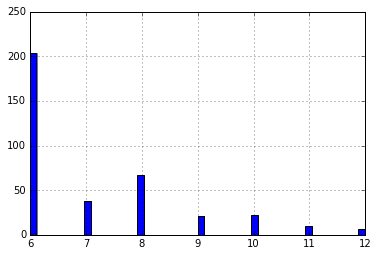

In [22]:
men_data = men_counts['Semestre']
women_data = women_counts['Semestre']

men_data.hist(bins = 50)


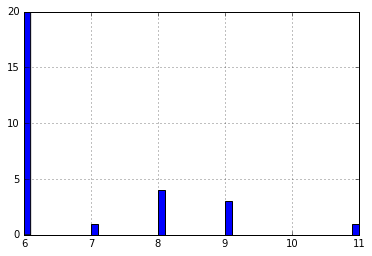

In [23]:
women_data.hist(bins = 50)

We test if the difference of the means between men and women is statistically significant.

In [120]:
from scipy.stats import ttest_ind

ttest_ind(men_data, women_data)


Ttest_indResult(statistic=1.0643000334248733, pvalue=0.2878429746516184)

We can see that it is not.

# Parameter Generation for the Master Students 

We begin by creating the new dictionary to get all of the list of master students

In [24]:
#parameters Period Master :Only the period (Bachelor to Master will be changed)

test = ['Mas','Pro','Min']#test = ["Ba", "Ma","Min","Mis","Pro","Sem","Sta"]
parameter_period_Master = {};
for key,value in dic_name_value.items():
    if key is not None: #checking for none because it exist in the keys. With this no error will be returned due to nonetype
        if key.startswith(tuple(test)):
            parameter_period_Master[key]=value
print(parameter_period_Master)

{'Master semestre 2': '942192', 'Master semestre 1': '2230106', 'Mineur semestre 2': '2335676', 'Mineur semestre 1': '2335667', 'Master semestre 3': '2230128', 'Projet Master printemps': '3781783', 'Projet Master automne': '249127', 'Master semestre 4': '2230140'}


We now do as with the bachelor students and extract all the data in a single dataframe. For the extraction of the data, we choose to keep the data from 2016 so that we can count all of those who finish, and we will erase those who just arrive in 2016 from our dataset.

In [25]:
data_master = pd.DataFrame()
for key_section,value_section in parameter_section.items():
    for key_years,value_years in parameter_years.items():
        for key_period,value_period in parameter_period_Master.items():
            for key_semester,value_semester in parameter_semester.items():
                  #We use a try to prevent the problem when there is a empty list.
                try:
                    #The url is changed for every values in each loops
                    student_data = pd.read_html('http://isa.epfl.ch/imoniteur_ISAP//!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=%s&ww_x_PERIODE_ACAD=%s&ww_x_PERIODE_PEDAGO=%s&ww_x_HIVERETE=%s' % (value_section, value_years, value_period, value_semester),header=None)
                    
                    #The data is reshaped to be more suite for subsequent analysis
                    student_data = student_data[0]
                    student_data.columns = student_data.loc[[1]].values.reshape(12,)
                    student_data.drop(student_data.index[[0,1]],inplace=True)
                    student_data = student_data[['Civilité','Nom Prénom','Spécialisation','Mineur']]
                    student_data['Période Académique'] = key_period
                    student_data['Year'] = key_years
                    data_master = pd.concat([data_master, student_data], axis = 0)# we could use keys here
                except:
                    pass
                
                #Each block of data is concatenated to have a unique dataframe


We first take a look at the data we extracted

In [27]:
data_master.head()

,Civilité,Nom Prénom,Spécialisation,Mineur,Période Académique,Year
2,Madame,Abbadi Hajar,NaN,"Mineur en Management, technologie et entrepren...",Master semestre 2,2013-2014
3,Monsieur,Ahmed Fayzan,NaN,Mineur en Neuroprosthétiques,Master semestre 2,2013-2014
4,Monsieur,Angel Axel,NaN,NaN,Master semestre 2,2013-2014
5,Madame,Antic Jelena,NaN,NaN,Master semestre 2,2013-2014
6,Monsieur,Antognini Marco,NaN,NaN,Master semestre 2,2013-2014


We have  extract all of the data for the master students. The first step will be to check how many of them have only been signep up only once. We choose to look only at the type of semester the student is signed up in, and not to look at the timeline of his inscriptions. Due to this, if the master student is leaving 1 semester for a long internship it will not be counted in the total time for his master. We think this assumption is okay because we are only looking at the time that is required to finis the master courses, and not making internships in between!

In [28]:
signUprate = data_master['Nom Prénom'].value_counts()
print('How many are signed up only once :',signUprate.value_counts().loc[1])
print('Total number of students : ',len(signUprate))

How many are signed up only once : 185
Total number of students :  977


As we see that 185 students are only signed up once, it's hard to believe that 20 % have stopped the masters in mid course.

We want to take a look at these 185 students and see if it is an IS_academia artifact or if they really signed up only in the first semester and left. We will extract these from the whole data_master dataFrame.

In [29]:
import numpy as np
signUponce = (data_master['Nom Prénom'].value_counts()==1)
signUponcename = signUponce.loc[signUponce == True].index
signUponcename = np.array(signUponcename)

Students_once = data_master[data_master['Nom Prénom'].isin(signUponcename)]
print('Période Académique\n',Students_once['Période Académique'].value_counts())

Période Académique
 Master semestre 1    137
Master semestre 3     45
Master semestre 2      3
Name: Période Académique, dtype: int64


We can see that about 10% of the registered students were signed up only once in Master Semester 1, and then are not seen any more. We will look more closely at the three types of students. These disappearances are also due that some students have only signed up to masters in 2016 and have just started, not yet finished. We do not want to count them in our statistics.

In [30]:
MA1 = Students_once[Students_once['Période Académique'] == 'Master semestre 1']
MA2 = Students_once[Students_once['Période Académique'] == 'Master semestre 2']
MA3 = Students_once[Students_once['Période Académique'] == 'Master semestre 3']
print('Number MA1',len(MA1),'No minor',MA1['Mineur'].isnull().sum(),\
     'No Specialization',MA1['Spécialisation'].isnull().sum())
print('Number MA2',len(MA2),'No minor',MA2['Mineur'].isnull().sum(),\
     'No Specialization',MA2['Spécialisation'].isnull().sum())
print('Number MA3',len(MA3),'No minor',MA3['Mineur'].isnull().sum(),\
     'No Specialization',MA3['Spécialisation'].isnull().sum())

Number MA1 137 No minor 135 No Specialization 128
Number MA2 3 No minor 3 No Specialization 3
Number MA3 45 No minor 41 No Specialization 23


We see that most of the students that are signed up in a minor or a specialization are in MA2 or MA3, therefore we will make the assumption that the students that have disapeared from MA1 have left EPFL for good. For the other students we will take into account the fact that they are only registered in one semester and add the according number. 

We will begin by removing all the students registered only in MA1 from the database

In [31]:
MA1names = Students_once.loc[Students_once['Période Académique'] =='Master semestre 1']
names = np.array(MA1names['Nom Prénom'])
masterStudents = data_master[data_master['Nom Prénom'].isin(names) == False]

Now that we have removed the data that is of no interest to us we will check for missing entries. We have decided on several parameters that will alter the number of semesters a student is signed up in. 

- If the student has not been signed up to the master project: + 1 semester
- If the student has a specialization or minor, no master project and only 2 semesters: + 2 semester
- If the student has a master project and a specialization or minor but only 3 semesters : + 1 semester


In [32]:
def check_student(studentDF):
    #check if signed if to master project, in autumn or spring
    numberSem = len(studentDF)
    
    #boolean value to represent that will be true if the student was signed in a Master project
    PDM = ((studentDF['Période Académique'] == 'Projet Master printemps').any()\
    or (studentDF['Période Académique'] == 'Projet Master automne').any())
    
    #Booleans for minor and specialization that will be true if no minor
    Minor = studentDF['Mineur'].notnull().any()
    Specialization = studentDF['Spécialisation'].notnull().any()
    
    #add a semester when he is not signed up to PDM
    if not PDM:
        numberSem+=1
    
    
    if Minor or Specialization:
        if numberSem < 3:
            numberSem+=2
        elif numberSem < 4:
            numberSem+=1
        #with this last statement we take care of the students that are only signed up once
        #with no spec / minor and PDM, and who should end up with 3 semesters
        else:
            numberSem+=1
    
    #last check to be sure that no one has less than 3 semesters
    if numberSem<3:
        numberSem=3
        
    return numberSem

Now we can groupby the remaining students, and check for each students if they have the appropriate smester number, and change the value if necessary.

In [33]:
groupedStudents = masterStudents.groupby('Nom Prénom')

Now we scroll through each student, compute the appropriate number of semesters

In [35]:
listSemester = []
i = 1
for student in groupedStudents.groups:
    Stud = groupedStudents.get_group(student)
    Sem = check_student(Stud)
    listSemester.append(Sem)

listSemester = np.asarray(listSemester)
print('Mean number of semesters : ',np.mean(listSemester))

Mean number of semesters :  4.56666666667


As we can see, on average a master student at EPFL in computer science takes 4.55 semesters to finish his masters. We think it's normal that's is a bit higher than 4 because until now each time a student leaves for an internship / other, sometimes he will disappear from IS-Academia, and sometimes he will be signed up as MA-1 or MA-2 and we will count these semesters as study time even if it was not our goal.

## Separate by Specialization

We will first extract the different specialization by grouping and then counting the number of semesters for each specialization.

In [36]:
specGroup = data_master.groupby('Spécialisation')
nameSpec =[]

yearSpec = pd.DataFrame()

#We scroll through each specialization and then we group by student
#to compute their number of years. and then we put the values for each student in a Data Frame
for gr in specGroup.groups:
    sp = specGroup.get_group(gr)
    spGroups = sp.groupby('Nom Prénom')
    specList = []
    nameSpec.append(gr)
    for nameStudent in spGroups.groups:
        nStudent = spGroups.get_group(nameStudent)
        year = check_student(nStudent)
        specList.append(year)
        
    intStudent = pd.DataFrame()
    intStudent[gr]= np.asarray(specList).astype(np.float)
    yearSpec = pd.concat([yearSpec,intStudent],axis=1)

We just take a look at the data!

In [39]:
yearSpec.head()

,Computer Science Theory,Software Systems,Foundations of Software,Information Security - SP,Computer Engineering - SP,Data Analytics,Internet Information Systems,"Signals, Images and Interfaces",Service science,Biocomputing,Internet computing
0,4.0,4.0,7.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
1,NaN,6.0,4.0,4.0,6.0,4.0,NaN,6.0,4.0,4.0,5.0
2,NaN,6.0,5.0,6.0,6.0,4.0,NaN,4.0,4.0,4.0,5.0
3,NaN,4.0,4.0,4.0,5.0,4.0,NaN,5.0,5.0,4.0,7.0
4,NaN,4.0,6.0,4.0,4.0,5.0,NaN,4.0,5.0,4.0,4.0


Now that we have separated the students in each specialization we can look at the mean number of semesters, and then do the t test to check if they are significant. We can already see that for most of the specializations there are not enough students to come to an appropriate conclusion.

In [40]:
yearSpec.mean()

Computer Science Theory           4.000000
Software Systems                  4.473684
Foundations of Software           4.884058
Information Security - SP         4.285714
Computer Engineering - SP         4.590909
Data Analytics                    4.125000
Internet Information Systems      4.000000
Signals, Images and Interfaces    4.800000
Service science                   4.400000
Biocomputing                      4.166667
Internet computing                4.666667
dtype: float64

Even without the t test we already see that the more samples a specialization has the higher the mean is, so it will be hard to make a correct conclusion. 

We use the listSemester variable containing the numbero of semesters for all students, that represents the mean of the population and we will do a one sample t-test to know if the students from one specialization are different from the population.

In [42]:
import scipy.stats as stats

#We go through each specialization and test in respect to each
TTest = pd.DataFrame()

for name in yearSpec:
    t_result = []
    t_test = stats.ttest_1samp(a= yearSpec[name].dropna().values,
                                 popmean=listSemester.mean()) 
                          
    t_result.append(t_test[1]) 
     
    TTest[name]=np.asarray(t_result).astype(np.float)      

/Users/thomasvetterli/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


We choost a 5% p value and will check which specialization have a mean differene which is significant.

In the next table we show which combinations are significant. We can see that not a lot of differences in distribution are significant.

In [44]:
signif = TTest[TTest<0.05]
signif

,Computer Science Theory,Software Systems,Foundations of Software,Information Security - SP,Computer Engineering - SP,Data Analytics,Internet Information Systems,"Signals, Images and Interfaces",Service science,Biocomputing,Internet computing
0,NaN,NaN,0.006137,NaN,NaN,0.009555,NaN,NaN,NaN,0.004475,NaN


We see that only Foundations of Software, Biocomputing and Data Analytics specialisation have an average that is statistically signficant.

In [45]:
for name in yearSpec:
    numberObs = yearSpec[name].notnull().sum()
    print('Specialization : ', name, '-- Number of students :', numberObs)

Specialization :  Computer Science Theory -- Number of students : 1
Specialization :  Software Systems -- Number of students : 19
Specialization :  Foundations of Software -- Number of students : 69
Specialization :  Information Security - SP -- Number of students : 7
Specialization :  Computer Engineering - SP -- Number of students : 22
Specialization :  Data Analytics -- Number of students : 8
Specialization :  Internet Information Systems -- Number of students : 1
Specialization :  Signals, Images and Interfaces -- Number of students : 40
Specialization :  Service science -- Number of students : 5
Specialization :  Biocomputing -- Number of students : 12
Specialization :  Internet computing -- Number of students : 108


We see that for Data Analytics and Biocomputing there are not a lot of students, sot we do not trust the 1 sample t-test. 

But for the foundations of software students, as a lot of them are signed up we can trust that the difference is significant. Let's look at the actual difference to see if it is larger or smaller.

In [48]:
print('Mean number of semester : ', np.mean(listSemester))
print('Mean number of semester for Foundations of Soft Students :',
      yearSpec['Foundations of Software'].mean())

Mean number of semester :  4.56666666667
Mean number of semester for Foundations of Soft Students : 4.884057971014493


So we can see that on average they take 0.2 semesters longer!

## Bonus question

Firstly, seeing the very small numbers of girls that are signed up to the masters in Informatics it will be hard to compute over time if the value changes. We will start by doing a general comparison as we did in bachelor.

In [50]:
groupCiv = masterStudents.groupby('Civilité')
men = groupCiv.get_group('Monsieur')
women = groupCiv.get_group('Madame')

As before we will loop through all of the students to compute their average number of years.

In [51]:
menGroup = men.groupby('Nom Prénom')
womenGroup = women.groupby('Nom Prénom')

menSem = []
womenSem = []

for name in menGroup.groups:
    guy = menGroup.get_group(name)
    numberYear = check_student(guy)
    menSem.append(numberYear)
    
for name in womenGroup.groups:
    girl = womenGroup.get_group(name)
    nyear = check_student(girl)
    womenSem.append(nyear)

menSem = np.asarray(menSem).astype(np.float)
womenSem= np.asarray(womenSem).astype(np.float)

Now that we have the number of years for men and women we can test if they are statistically significant. 

We use a 2 sample t test, and we assume that the variance is equal

In [58]:
print(stats.ttest_ind(a=menSem,b=womenSem))
print('Women Mean :',womenSem.mean())
print('Men Mean :', menSem.mean())

Ttest_indResult(statistic=0.0027122023582316175, pvalue=0.99783662376363136)
Women Mean : 4.56637168142
Men Mean : 4.56671251719


As expected by looking at the means, there is no difference between the number of semesters that a woman or a man has to do to do the masters.

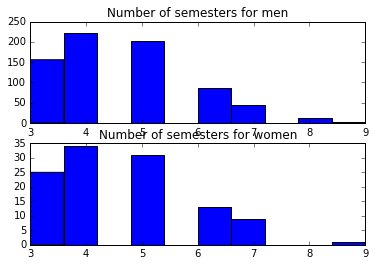

In [59]:
plt.subplot(2,1,1)
plt.hist(menSem)
plt.title('Number of semesters for men')

plt.subplot(2,1,2)
plt.hist(womenSem)
plt.title('Number of semesters for women')


As expected the histograms are nearly the same!

The analysis of the difference over time will take us too much time so we will not do it